<a href="https://colab.research.google.com/github/qianjing2020/DS-Unit-2-Kaggle-Challenge/blob/master/JingQian_assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# settings and libraries

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"# this will display multiple variables/statements at once for variable on this own line

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [35]:
# get data
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [36]:
# split train into train and val
train, val = train_test_split(train, train_size = 0.9, test_size=0.1, stratify=train['status_group'], random_state=42)
train.shape, val.shape, test.shape

((53460, 41), (5940, 41), (14358, 40))

In [37]:
def plotTanzaniaPump(data):
  fig = plt.figure()
  ax = px.scatter(data,x='longitude', y='latitude', color='status_group', opacity=0.5)
  plt.show()
  return ax

plotTanzaniaPump(train)

<Figure size 576x396 with 0 Axes>

In [38]:
# clean the data

def wrangle(X):
  # clean data 
  # prevent SettingWithCopyWarning
  X = X.copy()
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  cols_with_zeros =['longitude', 'latitude','construction_year', 'population', 'gps_height']
  for col in cols_with_zeros:
    X[col]=X[col].replace(0, np.nan)
  
  X = X.drop(columns = ['recorded_by', 'num_private', 'amount_tsh'])
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])

  return X

train = wrangle(train) 
val = wrangle(val)
test = wrangle(test)
plotTanzaniaPump(train)

<Figure size 576x396 with 0 Axes>

In [39]:
train.shape, val.shape, test.shape

((53460, 38), (5940, 38), (14358, 37))

In [40]:
# exploratory visualizations
# Pandas Profiling can be very slow with medium & large datasets.
# These parameters will make it faster.
# https://github.com/pandas-profiling/pandas-profiling/issues/222
import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [0]:
# # create a new label column "status_int" so each label now is replaced by an int
# from sklearn.preprocessing import LabelEncoder
# lb_make = LabelEncoder()
# train['status_int'] = lb_make.fit_transform(train['status_group'])
# train[['status_group', 'status_int']].tail(10)

In [41]:
# select target 
target = 'status_group'
# select features
train_features = train.drop(columns = [target])

# numerica features
num_features = train_features.select_dtypes(include='number').columns.to_list()
print('numerical features:', num_features)

# get cardinality for non-numeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
#nunique() function return Series with number of distinct observations over requested axis. 
#default axis=0, so it finds the total number of unique observations over the index axis.
cat_features = cardinality[cardinality<50].index.to_list()
print('categorical features:', cat_features)

# combine the features
features = num_features + cat_features

numerical features: ['id', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year']
categorical features: ['basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [43]:
# find baseline accuracy
y_train = train['status_group']
y_train.value_counts(normalize=True)

from sklearn.metrics import accuracy_score, mean_absolute_error
majorityclass = y_train.mode()
y_pred = [majorityclass]*len(y_train)
print('\n Baseline accuracy score =', accuracy_score(y_pred, y_train))

functional                 0.543079
non functional             0.384250
functional needs repair    0.072671
Name: status_group, dtype: float64


 Baseline accuracy score = 0.543078937523382


In [27]:
# use pipeline import numpy as np
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier


train_accu_all = []
val_accu_all =[]
depth = []
for max_depth in range(10, 30):
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(strategy = 'median'),
      DecisionTreeClassifier(max_depth = max_depth, random_state=42)
  );

  # Fit the train
  pipeline.fit(X_train, y_train)
  # score on val
  print(f'\n max_depth = {max_depth}:')
  print('Train accuracy', pipeline.score(X_train, y_train))
  print('Validation accuracy', pipeline.score(X_val, y_val))

  train_accu = pipeline.score(X_train, y_train)
  val_accu = pipeline.score(X_val, y_val)

  train_accu_all.append(train_accu)
  val_accu_all.append(val_accu)
  depth.append(max_depth)



Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=10, max_features=No


 max_depth = 10:
Train accuracy 0.7566965955854845
Validation accuracy 0.7437710437710437


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=11, max_features=No


 max_depth = 11:
Train accuracy 0.7666479610924055
Validation accuracy 0.7476430976430977


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=12, max_features=No


 max_depth = 12:
Train accuracy 0.7803030303030303
Validation accuracy 0.7542087542087542


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=13, max_features=No


 max_depth = 13:
Train accuracy 0.7944444444444444
Validation accuracy 0.7611111111111111


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=14, max_features=No


 max_depth = 14:
Train accuracy 0.8076505798728021
Validation accuracy 0.7621212121212121


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=15, max_features=No


 max_depth = 15:
Train accuracy 0.8200710811821923
Validation accuracy 0.765993265993266


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=16, max_features=No


 max_depth = 16:
Train accuracy 0.8338009726898615
Validation accuracy 0.7705387205387205


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=17, max_features=No


 max_depth = 17:
Train accuracy 0.8468761690983914
Validation accuracy 0.7735690235690236


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=18, max_features=No


 max_depth = 18:
Train accuracy 0.8615600448933782
Validation accuracy 0.7713804713804714


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=19, max_features=No


 max_depth = 19:
Train accuracy 0.8753834642723531
Validation accuracy 0.7772727272727272


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=20, max_features=No


 max_depth = 20:
Train accuracy 0.8897493453049009
Validation accuracy 0.7752525252525253


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=21, max_features=No


 max_depth = 21:
Train accuracy 0.9029180695847363
Validation accuracy 0.7739057239057239


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=22, max_features=No


 max_depth = 22:
Train accuracy 0.9143471754582866
Validation accuracy 0.7722222222222223


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=23, max_features=No


 max_depth = 23:
Train accuracy 0.9252899364010475
Validation accuracy 0.7661616161616162


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=24, max_features=No


 max_depth = 24:
Train accuracy 0.9352600074822297
Validation accuracy 0.7656565656565657


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=25, max_features=No


 max_depth = 25:
Train accuracy 0.9432846988402543
Validation accuracy 0.7646464646464647


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=26, max_features=No


 max_depth = 26:
Train accuracy 0.9511223344556677
Validation accuracy 0.763973063973064


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=27, max_features=No


 max_depth = 27:
Train accuracy 0.9578750467639356
Validation accuracy 0.7646464646464647


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=28, max_features=No


 max_depth = 28:
Train accuracy 0.9642349420127198
Validation accuracy 0.7661616161616162


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=29, max_features=No


 max_depth = 29:
Train accuracy 0.9699588477366256
Validation accuracy 0.7634680134680135


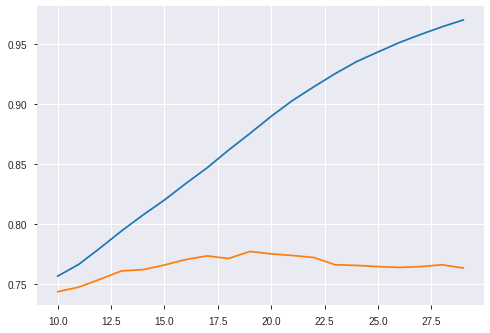

In [44]:
plt.plot(depth, train_accu_all)
plt.plot(depth, val_accu_all)

# looks max_depth = 19 gives the best validation accuracy

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=19, max_features=No

Train Accuracy 0.8780022446689113
Validation Accuracy 0.7681818181818182


<Figure size 720x2160 with 0 Axes>

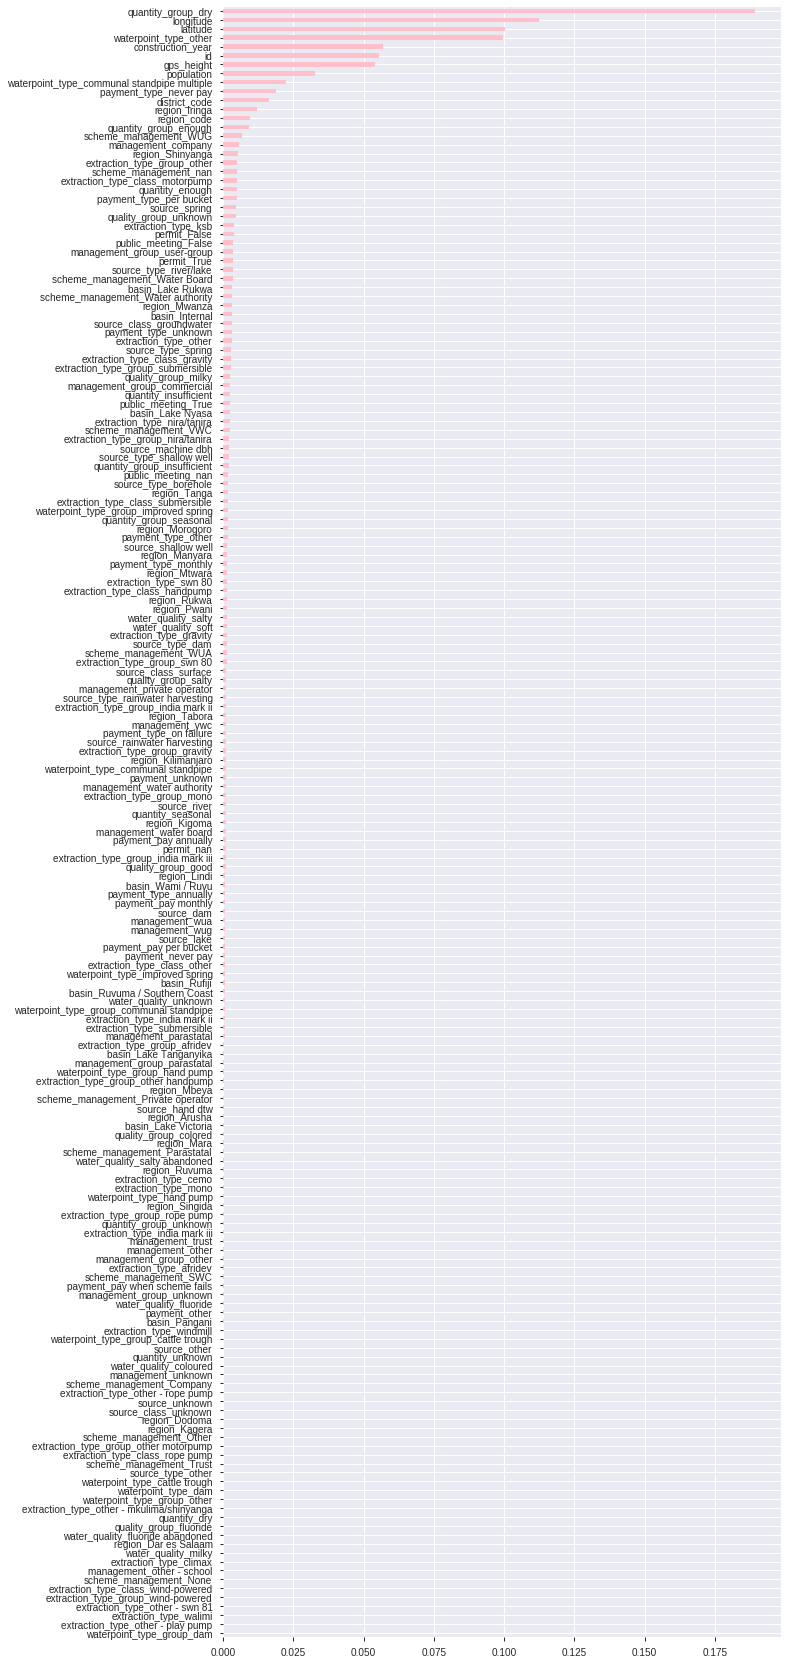

In [45]:
# use the max_depth of 19
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    DecisionTreeClassifier(max_depth=19, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# plot importances of features
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns 
y_pred = pipeline.predict(X_test)
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color = 'pink')


In [46]:
# save prediction and submit to kaggle
df = X_test
df['status_group'] = y_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
submission = df[['id', 'status_group']]
submission.to_csv(r'prediction.csv', index=False)
from google.colab import files
files.download('prediction.csv')